<a href="https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png" class="oc-imageLink oc-imageLink--disabled"><img src="https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png" alt="Logo de La poule qui chante"></a>

   # <font color='indianred'>Produisez une étude de marché avec R ou Python</font>

  ## <font color='indianred'> Sommaire<font></a>
    
**Notebook 1 - Préparation - Nettoyage - Analyse Exploratoire**

    
## <a href="#C1">Présentation du projet<font></a> 
    
- <a href="#C2"> 1.Rappel du contexte</a>
- <a href="#C3"> 2.Mission et objectifs</a>
- <a href="#C4"> 3.Démarche à suivre</a>

    
## <a href="#C5">Partie 1 : Importation et Inspection des données<font></a>

- <a href="#C6"> 1. Importation  des librairies et chargement des données</a> 
- <a href="#C7"> 2. Fonctions utiles </a> 
- <a href="#C8"> 3. Nettoyage des données et analyse exploratoire (hors ACP)</a>
- <a href="#C9">3.1 Fichier Disponibilité_Alimentaire</a>
     - <a href="#C10"> Exportations poulet</a>
     - <a href="#C11"> Importations poulet</a>
     - <a href="#C12"> Nourriture poulet</a>
     - <a href="#C13"> Production poulet</a>
- <a href="#C14">3.2 Fichier Population</a>
- <a href="#C15">3.3 Fichier Pib Par Habitant</a>
- <a href="#C16">3.4 Fichier Stabilité Politique</a>

## <a href="#C17">Partie 2 : Préparation des données<font></a>

- <a href="#C18">1. Jointure des dataframes </a>
- <a href="#C19">2. Corrélation entre les variables </a>
    
## <a href="#C20">Partie 3 : Analyse en composantes principales (ACP)<font></a>
    
- <a href="#C21">1. Centrage et réduction des données</a>
- <a href="#C22">2. Détermination du nombre de composantes principales</a>
- <a href="#C23">3.  Création de l'éboulis des valeurs propres</a>
- <a href="#C24">4.  Construction des composantes principales</a>
- <a href="#C25">5.  Cercles de corrélations</a>
- <a href="#C26">6.  Projection des pays sur les axes F1 et F2</a>
    
## <a href="#C27">Partie 4 : Export<font></a> 
       
**Notebook 2 - Clustering - Visualisation**

**Partie 5- Clustering**

## <a name="C1"><font>Présentation du projet</font></a>

<a name="C2">1. Rappel du contexte</a>

La Poule qui chante est une entreprise française d'agroalimentaire qui souhaite se développer à l'international.
"L'international, oui, mais pour l'instant, le champ des possibles est bien large : aucun pays particulier ni aucun continent n'est pour le moment choisi. Tous les pays sont envisageables !"

<a name="C3">2.Mission et objectifs </a>
 
**- Objectif** :
- Proposer une première analyse des groupements de pays pouvant être ciblés pour l'export des poulets dans le but d'approfondir ensuite l'étude de marché.

**- Mission**:
- Notre mission est d'identifier les pays les plus favorables pour pénétrer le marché de la volaille. Pour sélectionner les pays cibles de manière éclairée, il est impératif de mener une analyse approfondie sur plusieurs facteurs clés. Ces derniers incluent la disponibilité alimentaire dans chaque pays, la stabilité politique, le Produit Intérieur Brut par habitant, ainsi que la démographie..

- Pour mener à bien notre mission nous utiliserons des données issues du site de la FAO.

<a name="C4">3.Démarche à suivre </a>

Pour parvenir à réaliser au mieux cette mission, quelques étapes indispensables seront nécessaires:

   - Analyse exploratoire des données (hors ACP)
   - Une analyse en Composantes principales est à réaliser pour visualiser les résultats des classifications,comprendre les     liens entre les variables, les liens entre les individus..
   - Clustering(classification des pays) , 2 méthodes sont à tester : 
   - Méthode 1:Classification ascendante hiérarchique (CAH), avec un dendrogramme comme visualisation 
   - Méthode 2: Méthode des k-means
   
Les résultats des 2 méthodes seront analysés et comparés.

## <a name="C5"><font>Partie 1 : Importation et Inspection des données</font></a>

### <a name="C6">1. Importation  des librairies et chargement des données</a>

In [222]:
# Librairies de calcul:
import pandas as pd
import numpy as np

# Librairies de visualisation:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import seaborn as sns

import scipy.stats as st

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [223]:
#Import des fichiers csv extraits directement de la base de données du site de la FAO
#http://www.fao.org/faostat/fr/#data

dispo = pd.read_csv("Disponibilite_Alimentaire_2017.csv")
pib = pd.read_csv("PIB_2017.csv")
pop = pd.read_csv("Population_2000_2018.csv")
stab = pd.read_csv("Stabilité_Politique_2017.csv")

### <a name="C7">2.Fonctions utiles</a>

In [224]:
#Fonction pour détecter valeurs manquantes et les doublons
def decrire_dataframe(df: pd.DataFrame):
    """
    Retourner un dataframe avec des informations sur les colonnes d'un dataframe
    """
    desc = df.columns.to_frame(name="column").set_index('column') #construire le dataframe résultats
    desc['count'] = df.notnull().sum() #count de values non nulls
    desc['unique'] = df.nunique() # nombre de values unique
    desc['dtype'] = df.dtypes # type de données dans chque colonne
    desc['count_null']=df.isna().sum() #count de valeurs nulls
    desc['null%']=round((df.isna().sum()/df.shape[0]*100),2)
    desc['duplicated']=df.duplicated().sum() # nombre de valeurs en doubles
    return desc

#Vérifier l'unicité de la clé primaire
#Creation d'une fonction qui teste l'unicité d'une colonne  

def cle_primaire(df,col):
    if len(df)==len(df[col].unique()):
        print('La variable', col, 'est une clé primaire')
    else: 
        print('La variable',col, 'n\'est pas une clé primaire')
        

def is_zero(cell_value, color='pink'):
    """
    style pour souligné une valeur
    example use:
    df.style.applymap(is_zero,subset=["my_col"],color='red')
    """
    return f'background-color: {color};' if cell_value == 0 else None

In [225]:
#Fonction pour traçer les cercles de corrélations
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(15, 11))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [226]:
#Fonction pour la projection des pays sur le plan factoriel
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour PC1, PC2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # Forme de la figure
    if not figsize: 
        figsize = (7,6)

    # Labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # Vérification de la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # Définition de x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Vérification de la présence de clustrers ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'PC{x+1} {v1}')
    ax.set_ylabel(f'PC{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # Bornes pour x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur PC{x+1} et PC{y+1})")
    plt.show()

### <a name="C8"> 3. Nettoyage des données et analyse exploratoire (hors ACP)</a>
***- Chercher les différentes erreurs dans les 4 fichiers, essayer de les corriger afin de permettre une jointure éventuelle des 3 fichiers.***

### <a name="C9"> 3.1 Fichier Disponibilité_Alimentaire</a>

In [227]:
#Vérifier les différentes informations et voir quels variables contiennent des valeurs manquantes
dispo.info()
dispo.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,176600.000000,176600.000000,176600.000000,176600.0,176600.0,176600.000000
mean,125.474740,3810.052894,2628.778545,2017.0,2017.0,210.554918
std,72.941699,2211.790089,91.993247,0.0,0.0,4762.047787
min,1.000000,645.000000,2511.000000,2017.0,2017.0,-10388.000000
25%,63.000000,684.000000,2556.000000,2017.0,2017.0,0.000000
50%,120.000000,5142.000000,2612.000000,2017.0,2017.0,0.120000
75%,188.000000,5301.000000,2732.000000,2017.0,2017.0,8.462500
max,276.000000,5911.000000,2899.000000,2017.0,2017.0,758548.000000


In [228]:
#Afficher la dimention du dataframe
dispo.shape

(176600, 14)

In [229]:
(decrire_dataframe(dispo).reset_index().style
    .bar(axis='index', subset=['count'], color='green')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))

,column,count,unique,dtype,count_null,null%,duplicated
0,Code Domaine,176600,1,object,0,0.000000,0
1,Domaine,176600,1,object,0,0.000000,0
2,Code zone,176600,174,int64,0,0.000000,0
3,Zone,176600,174,object,0,0.000000,0
4,Code Élément,176600,17,int64,0,0.000000,0
5,Élément,176600,17,object,0,0.000000,0
6,Code Produit,176600,98,int64,0,0.000000,0
7,Produit,176600,98,object,0,0.000000,0
8,Code année,176600,1,int64,0,0.000000,0
9,Année,176600,1,int64,0,0.000000,0


In [230]:
#2017 étant l'année la plus récente disponible dans les bilans alimentaires de la FAO

#Affichage des colonnes 
print(dispo.columns)

#Méthode .pivot_table() afin de rendre le dataframe exploitable 
dispo_2017 = dispo.pivot_table(index=['Zone'], 
                                            columns='Élément', values='Valeur', fill_value=0, aggfunc=sum).reset_index()


dispo_2017 =dispo_2017[['Zone', 
                                'Exportations - Quantité', 
                                'Importations - Quantité', 
                                'Nourriture', 
                                'Production',
                                'Disponibilité alimentaire (Kcal/personne/jour)'
                       ]]
#Ensuite je renomme les colonnes suivantes:
dispo_2017.rename(columns={'Zone':'pays',
                           'Exportations - Quantité':'Exportations Total',
                           'Importations - Quantité': 'Importations total',
                           'Nourriture' : 'Nourriture Total',
                           'Production' : 'Production total',
                           'Disponibilité alimentaire (Kcal/personne/jour)':'dispo_al'},
                               inplace=True)

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole'],
      dtype='object')


In [231]:
# La colonne zone est transformée en index par la méthode pivot_table.
#L'analyse se focalise sur la vente de volailles, 
#donc j'instaure un filtre sur la disponibilité alimentaire qui se limite uniquement aux données liées à la viande de volailles.

poulet_2017 =dispo.pivot_table(index=['Zone','Produit'], 
                                            columns='Élément', 
                                            values='Valeur',
                                             fill_value=0).reset_index()
                                           
                                          

poulet_2017 = poulet_2017[poulet_2017['Produit'] == 'Viande de Volailles']

poulet_2017 =poulet_2017[['Zone', 
                                'Exportations - Quantité', 
                                'Importations - Quantité', 
                                'Nourriture', 
                                'Production',
                                 'Disponibilité alimentaire (Kcal/personne/jour)'
                       ]]
poulet_2017.rename(columns={'Zone':'pays',
                           'Exportations - Quantité':'Exportations poulet',
                            'Importations - Quantité': 'Importations poulet',
                            'Nourriture' : 'Nourriture poulet',
                            'Production' : 'Production poulet',
                            'Disponibilité alimentaire (Kcal/personne/jour)':'poulet_al'},
                               inplace=True)


poulet_2017.head() 

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
78,Afghanistan,0,29,55,28,5
173,Afrique du Sud,63,514,2035,1667,143
265,Albanie,0,38,47,13,85
357,Algérie,0,2,264,275,22
452,Allemagne,646,842,1609,1514,71


In [232]:
# Les valeurs à "0" correspondent aux pays qui ne produisent pas de poulet ou qui ne font pas d'importation ou d'exportation de poulet.
#Jointure entre les deux tables

df_poulet_2017=pd.merge(poulet_2017,dispo_2017[['pays','dispo_al']],on='pays')
df_poulet_2017

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al
0,Afghanistan,0,29,55,28,5,1997
1,Afrique du Sud,63,514,2035,1667,143,2987
2,Albanie,0,38,47,13,85,3400
3,Algérie,0,2,264,275,22,3345
4,Allemagne,646,842,1609,1514,71,3559
...,...,...,...,...,...,...,...
167,Émirats arabes unis,94,433,412,48,147,3370
168,Équateur,0,0,324,340,83,2585
169,États-Unis d'Amérique,3692,123,18100,21914,219,3762
170,Éthiopie,0,1,14,14,0,2304


In [233]:
#Création d'un nouveau champ(taux de consomation volaille)pour l'analyse.
df_poulet_2017['taux consommation volaille']=(df_poulet_2017['poulet_al']/df_poulet_2017['dispo_al'])*100
df_poulet_2017.sort_values('taux consommation volaille',ascending=False)

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille
6,Antigua-et-Barbuda,0,7,5,0,233,2429,9.592425
135,Sainte-Lucie,0,10,10,1,241,2658,9.066968
13,Bahamas,0,24,16,6,182,2043,8.908468
134,Saint-Vincent-et-les Grenadines,0,9,8,0,243,2962,8.203916
56,Grenade,0,7,5,1,192,2404,7.986689
...,...,...,...,...,...,...,...,...
105,Niger,0,3,20,19,3,2575,0.116505
149,Tchad,0,1,7,6,2,2092,0.095602
78,Kenya,0,0,34,35,2,2125,0.094118
106,Nigéria,0,0,192,201,2,2460,0.081301


### Analyse univariée

In [234]:
#Je définit une fonction pour l'analyse
def analyse_univarie(df, colonne, nbins = 50, log_y = False):
    print("Description rapide")
    print(df[colonne].describe())

    fig = px.histogram(df, x= colonne, nbins= nbins, log_y= log_y)
    fig.show()

    print("--------------------")
    print("Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.")
    print(f"Skewness: {df[colonne].skew()}")
    print(f"Kurtosis: {df[colonne].kurt()}")

In [235]:
#Ici, on va s'intéresser plus particulièrement à chacune des variables.
poulet_2017.head()

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
78,Afghanistan,0,29,55,28,5
173,Afrique du Sud,63,514,2035,1667,143
265,Albanie,0,38,47,13,85
357,Algérie,0,2,264,275,22
452,Allemagne,646,842,1609,1514,71


### <a name="C10">Exportations poulet</a>

In [236]:
#On réalise une description rapide.

poulet_2017['Exportations poulet'].describe()

count     172.000000
mean      103.750000
std       458.066125
min         0.000000
25%         0.000000
50%         0.000000
75%        12.000000
max      4223.000000
Name: Exportations poulet, dtype: float64

In [237]:
analyse_univarie(poulet_2017,'Exportations poulet')

Description rapide
count     172.000000
mean      103.750000
std       458.066125
min         0.000000
25%         0.000000
50%         0.000000
75%        12.000000
max      4223.000000
Name: Exportations poulet, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 7.3912924275999625
Kurtosis: 59.95692289814235


**On constate que la majorité des pays exportent peu de poulet entre 0 et 100 000 tonnes mais certains en exportent plus d'un million de tonnes. Quels sont ces pays ?**

In [238]:
#J'affiche les pays qui ont une exportation supérieur à un million de tonnes de poulet
poulet_2017[poulet_2017['Exportations poulet']>1000].sort_values('Exportations poulet',ascending=False)

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
2073,Brésil,4223,3,9982,14201,204
15860,États-Unis d'Amérique,3692,123,18100,21914,219
11036,Pays-Bas,1418,608,346,1100,70
11227,Pologne,1025,55,1150,2351,107


**Nous avons maintenant identifié les quatre plus grands exportateurs de viande de volaille dans le monde.**

### <a name="C11"> Importations poulet</a>

In [239]:
analyse_univarie(poulet_2017,'Importations poulet')

Description rapide
count     172.000000
mean       88.488372
std       185.824620
min         0.000000
25%         3.000000
50%        16.000000
75%        79.750000
max      1069.000000
Name: Importations poulet, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 3.3389744604199065
Kurtosis: 11.66500629821301


**La plupart des pays importent moins de 400 000 tonnes de poulet, mais certains en importent plus. Voyons quels sont ces pays?**

In [240]:
#J'affiche les pays qui ont une importation supérieur à 400 mille tonnes de poulet
poulet_2017[poulet_2017['Importations poulet']>400].sort_values('Importations poulet',ascending=False)

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
7143,Japon,10,1069,2359,2215,67
9259,Mexique,9,972,4058,3249,123
3014,Chine - RAS de Hong-Kong,663,907,391,24,210
452,Allemagne,646,842,1609,1514,71
11696,Royaume-Uni de Grande-Bretagne et d'Irlande du...,359,779,2131,1814,120
735,Arabie saoudite,10,722,1435,616,151
11036,Pays-Bas,1418,608,346,1100,70
173,Afrique du Sud,63,514,2035,1667,143
4898,France,501,506,1485,1750,92
6572,Iraq,0,470,561,96,52


**Nous avons désormais identifié les douze pays qui sont les plus grands importateurs de viande de volaille au monde.**

### <a name="C12"> Nourriture poulet</a>

In [241]:
analyse_univarie(poulet_2017,'Nourriture poulet')

Description rapide
count      172.000000
mean       649.406977
std       2125.189092
min          0.000000
25%         27.500000
50%         94.500000
75%        353.750000
max      18100.000000
Name: Nourriture poulet, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 6.803898376356385
Kurtosis: 50.90548081760291


**La plupart des pays utilisent moins de 2 millions de tonnes de viande de volaille pour nourrir leur population,mais certains en utilisent plus.
Voyons quels sont ces pays?**

In [242]:
#J'affiche les pays qui ont une alimentation supérieur à 2 million de tonnes de poulet
poulet_2017[poulet_2017['Nourriture poulet']>2000].sort_values('Nourriture poulet',ascending=False)

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
15860,États-Unis d'Amérique,3692,123,18100,21914,219
3298,"Chine, continentale",576,452,17518,18236,59
2073,Brésil,4223,3,9982,14201,204
4993,Fédération de Russie,115,226,4509,4444,104
9259,Mexique,9,972,4058,3249,123
6289,Inde,4,0,2965,3545,7
7143,Japon,10,1069,2359,2215,67
6478,Iran (République islamique d'),45,6,2220,2174,96
11696,Royaume-Uni de Grande-Bretagne et d'Irlande du...,359,779,2131,1814,120
173,Afrique du Sud,63,514,2035,1667,143


**On constate ici que les pays qui consomment le plus de viande de volaille pour nourrir leur population
sont souvent les plus peuplés, ce qui est logique.**

### <a name="C13"> Production poulet</a>

In [243]:
analyse_univarie(poulet_2017,'Production poulet')

Description rapide
count      172.000000
mean       708.325581
std       2474.456332
min          0.000000
25%         11.000000
50%         66.000000
75%        368.750000
max      21914.000000
Name: Production poulet, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 6.8198812530837705
Kurtosis: 50.277322011953345


**On constate ici que la majorité  des pays produisent moins de 2,5 millions de tonnes de viande de volaille.
Mais quelques pays en produits jusqu'à 21 millions de tonnes.**

In [244]:
#J'affiche les pays qui ont une production supérieur a 2.5 millions de tonnes de poulet
poulet_2017[poulet_2017['Production poulet'] > 2500].sort_values('Production poulet',ascending=False)

Élément,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al
15860,États-Unis d'Amérique,3692,123,18100,21914,219
3298,"Chine, continentale",576,452,17518,18236,59
2073,Brésil,4223,3,9982,14201,204
4993,Fédération de Russie,115,226,4509,4444,104
6289,Inde,4,0,2965,3545,7
9259,Mexique,9,972,4058,3249,123


**Les pays avec de grandes populations sont aussi ceux qui produisent le plus deviandes de volailles pour subvenir aux besoins de leurs habitants.**

### <a name="C14">3.2 Fichier Population</a>

In [245]:
#Vérifier les différentes informations et voir quels variables contiennent des valeurs manquantes
pop.info()
pop.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,4411.000000,4411.0,4411.0,4411.000000,4411.000000,4.411000e+03
mean,132.202902,511.0,3010.0,2009.068238,2009.068238,2.963004e+04
std,75.854840,0.0,0.0,5.481539,5.481539,1.238029e+05
min,1.000000,511.0,3010.0,2000.000000,2000.000000,7.850000e-01
25%,68.000000,511.0,3010.0,2004.000000,2004.000000,3.921890e+02
50%,132.000000,511.0,3010.0,2009.000000,2009.000000,4.764741e+03
75%,195.000000,511.0,3010.0,2014.000000,2014.000000,1.821548e+04
max,299.000000,511.0,3010.0,2018.000000,2018.000000,1.427648e+06


In [246]:
pop.shape

(4411, 15)

In [247]:
(decrire_dataframe(pop).reset_index().style
    .bar(axis='index', subset=['count'], color='green')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))

,column,count,unique,dtype,count_null,null%,duplicated
0,Code Domaine,4411,1,object,0,0.000000,0
1,Domaine,4411,1,object,0,0.000000,0
2,Code zone,4411,238,int64,0,0.000000,0
3,Zone,4411,238,object,0,0.000000,0
4,Code Élément,4411,1,int64,0,0.000000,0
5,Élément,4411,1,object,0,0.000000,0
6,Code Produit,4411,1,int64,0,0.000000,0
7,Produit,4411,1,object,0,0.000000,0
8,Code année,4411,19,int64,0,0.000000,0
9,Année,4411,19,int64,0,0.000000,0


**On observe 4153 valeurs nulls de la variable 'Note':**
**Aucune importance puisque la variable (Note) ne sera pas utile dans l'analyse.**

In [248]:
#Affichage des colonnes 
print(pop.columns)
#Restriction des données sur l'année 2017
pop_2017 = pop[pop['Année'] == 2017]
# Pivoter le df pour avoir la population totale en colonne et ne conserver que les colonnes pertinentes
pop_2017= pop.pivot_table(index=['Zone'], columns='Année',values='Valeur',fill_value=0,).reset_index()


pop_2017 =pop_2017[['Zone',2017]]

pop_2017.rename(columns={2017:'Population en 2017','Zone':'pays'}, inplace=True)

pop_2017.head()

Index(['Code Domaine', 'Domaine', 'Code zone', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole', 'Note'],
      dtype='object')


Année,pays,Population en 2017
0,Afghanistan,36296.113
1,Afrique du Sud,57009.756
2,Albanie,2884.169
3,Algérie,41389.189
4,Allemagne,82658.409


### Analyse univariée

In [249]:
analyse_univarie(pop_2017,'Population en 2017')     

Description rapide
count    2.380000e+02
mean     3.171485e+04
std      1.313698e+05
min      0.000000e+00
25%      3.758138e+02
50%      5.030324e+03
75%      1.902303e+04
max      1.421022e+06
Name: Population en 2017, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 9.328329313879022
Kurtosis: 93.68920524061015


**On remarque qu'il y a des pays qui présentent une grande population .Quels sont ces pays?**

In [250]:
#Afficher les pays qui ont une grande population

pop_2017[pop_2017['Population en 2017'] >0.2].sort_values('Population en 2017',ascending=False)

Année,pays,Population en 2017
44,"Chine, continentale",1421021.791
84,Inde,1338676.785
223,États-Unis d'Amérique,325084.756
85,Indonésie,264650.963
141,Pakistan,207906.209
...,...,...
124,Montserrat,4.984
229,Îles Falkland (Malvinas),3.068
133,Nioué,1.609
204,Tokélaou,1.300


### <a name="C15">3.3 Fichier Pib Par Habitant</a>

In [251]:
#Vérifier les différentes informations et voir quels variables contiennent des valeurs manquantes
pib.info()
pib.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            211 non-null    object 
 1   Domaine                 211 non-null    object 
 2   Code zone (FAO)         211 non-null    int64  
 3   Zone                    211 non-null    object 
 4   Code Élément            211 non-null    int64  
 5   Élément                 211 non-null    object 
 6   Code Produit            211 non-null    int64  
 7   Produit                 211 non-null    object 
 8   Code année              211 non-null    int64  
 9   Année                   211 non-null    int64  
 10  Unité                   211 non-null    object 
 11  Valeur                  211 non-null    float64
 12  Symbole                 211 non-null    object 
 13  Description du Symbole  211 non-null    object 
 14  Note                    0 non-null      fl

,Code zone (FAO),Code Élément,Code Produit,Code année,Année,Valeur,Note
count,211.000000,211.0,211.0,211.0,211.0,211.000000,0.0
mean,131.327014,6119.0,22008.0,2017.0,2017.0,16886.035415,NaN
std,77.800307,0.0,0.0,0.0,0.0,25550.733577,NaN
min,1.000000,6119.0,22008.0,2017.0,2017.0,295.620936,NaN
25%,64.500000,6119.0,22008.0,2017.0,2017.0,2082.324019,NaN
50%,129.000000,6119.0,22008.0,2017.0,2017.0,6450.319585,NaN
75%,194.500000,6119.0,22008.0,2017.0,2017.0,19806.127104,NaN
max,351.000000,6119.0,22008.0,2017.0,2017.0,173611.814788,NaN


In [252]:
pib.shape

(211, 15)

In [253]:
(decrire_dataframe(pib).reset_index().style
    .bar(axis='index', subset=['count'], color='green')
    .applymap(is_zero, subset=['count', 'unique'], color='pink'))

,column,count,unique,dtype,count_null,null%,duplicated
0,Code Domaine,211,1,object,0,0.000000,0
1,Domaine,211,1,object,0,0.000000,0
2,Code zone (FAO),211,211,int64,0,0.000000,0
3,Zone,211,211,object,0,0.000000,0
4,Code Élément,211,1,int64,0,0.000000,0
5,Élément,211,1,object,0,0.000000,0
6,Code Produit,211,1,int64,0,0.000000,0
7,Produit,211,1,object,0,0.000000,0
8,Code année,211,1,int64,0,0.000000,0
9,Année,211,1,int64,0,0.000000,0


In [254]:
#2017 étant l'année la plus récente disponible dans les bilans alimentaires de la FAO

pib['Élément'] = "Valeur US dollars par habitant"

pib['Unité'] = "US dollars"


#Affichage des colonnes 
print(pib.columns)

 # Pivoter le df afin de conserver que les colonnes pertinentes
pib_2017= pib.pivot_table(index=['Zone'], columns='Année',values='Valeur',fill_value=0,).reset_index()

#Sélection des colonnes 'Zone' et 'Valeur', les autres ne sont pas nécessaires dans notre cas
pib_2017 = pib_2017[['Zone',2017]].copy()


pib_2017.rename(columns={2017:'pib par habitant','Zone':'pays'}, inplace=True)

pib_2017.head()

Index(['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole', 'Note'],
      dtype='object')


Année,pays,pib par habitant
0,Afghanistan,530.149831
1,Afrique du Sud,6723.928582
2,Albanie,4521.752219
3,Algérie,4134.936054
4,Allemagne,44670.222288


### Analyse univariée

In [255]:
analyse_univarie(pib_2017,'pib par habitant')     

Description rapide
count       211.000000
mean      16886.035415
std       25550.733577
min         295.620936
25%        2082.324019
50%        6450.319585
75%       19806.127104
max      173611.814788
Name: pib par habitant, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: 3.165296166045163
Kurtosis: 13.50959636462406


**On constate qu'il y a des pays qui présentent des grandes valeurs de pib par habitant**

In [256]:
#J'affiche la liste des pays qui présentent une prospérité économique très élevée
pib_2017.nlargest(n=10, columns=['pib par habitant'])

Année,pays,pib par habitant
114,Monaco,173611.814788
99,Liechtenstein,170875.739925
22,Bermudes,112877.376531
101,Luxembourg,110203.008202
175,Suisse,83353.597572
205,Îles Caïmanes,81255.112455
41,Chine - RAS de Macao,78985.632288
125,Norvège,75490.688450
83,Islande,71961.532046
82,Irlande,70491.993301


**On a un listing des 10 pays les plus riche au niveau économique au monde**

### <a name="C16">3.4 Fichier Stabilité Politique</a>

In [257]:
#Vérifier les différentes informations et voir quels variables contiennent des valeurs manquantes
stab.info()
stab.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            196 non-null    object 
 1   Domaine                 196 non-null    object 
 2   Code zone (FAO)         196 non-null    int64  
 3   Zone                    196 non-null    object 
 4   Code Élément            196 non-null    int64  
 5   Élément                 196 non-null    object 
 6   Code Produit            196 non-null    int64  
 7   Produit                 196 non-null    object 
 8   Code année              196 non-null    int64  
 9   Année                   196 non-null    int64  
 10  Unité                   196 non-null    object 
 11  Valeur                  196 non-null    float64
 12  Symbole                 196 non-null    object 
 13  Description du Symbole  196 non-null    object 
 14  Note                    0 non-null      fl

,Code zone (FAO),Code Élément,Code Produit,Code année,Année,Valeur,Note
count,196.000000,196.0,196.0,196.0,196.0,196.000000,0.0
mean,128.142857,6125.0,21032.0,2017.0,2017.0,-0.066480,NaN
std,75.523201,0.0,0.0,0.0,0.0,0.995164,NaN
min,1.000000,6125.0,21032.0,2017.0,2017.0,-2.940000,NaN
25%,62.500000,6125.0,21032.0,2017.0,2017.0,-0.655000,NaN
50%,126.500000,6125.0,21032.0,2017.0,2017.0,0.035000,NaN
75%,191.500000,6125.0,21032.0,2017.0,2017.0,0.755000,NaN
max,299.000000,6125.0,21032.0,2017.0,2017.0,1.920000,NaN


In [258]:
stab.shape

(196, 15)

In [259]:
#2017 étant l'année la plus récente disponible dans les bilans alimentaires de la FAO

#Affichage des colonnes 
print(stab.columns)

# Pivoter le df afin de conserver que les colonnes pertinentes
stab_2017= stab.pivot_table(index=['Zone'], columns='Année',values='Valeur',fill_value=0,).reset_index()

#Sélection des colonnes 'Zone' et 'Valeur', les autres ne sont pas nécessaires dans notre cas
stab_2017 = stab_2017[['Zone',2017]].copy()


stab_2017.rename(columns={2017:'stabilité politique','Zone':'pays'}, inplace=True)

stab_2017.head()

Index(['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Zone', 'Code Élément',
       'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité',
       'Valeur', 'Symbole', 'Description du Symbole', 'Note'],
      dtype='object')


Année,pays,stabilité politique
0,Afghanistan,-2.80
1,Afrique du Sud,-0.28
2,Albanie,0.38
3,Algérie,-0.92
4,Allemagne,0.59


### Analyse univariée

In [260]:
analyse_univarie(stab_2017,'stabilité politique')

Description rapide
count    196.000000
mean      -0.066480
std        0.995164
min       -2.940000
25%       -0.655000
50%        0.035000
75%        0.755000
max        1.920000
Name: stabilité politique, dtype: float64


--------------------
Évaluation de la distribution avec les coefficients d'assymétrie et de Kurtosis.
Skewness: -0.6649331765917285
Kurtosis: 0.0598014291600264


**On constate  une asymétrie négative qui nous indique que l'on a plus de pays avec une valeur positive que négative**

In [261]:
#J'affiche la liste des pays qui présentent une stabilité politique >0
stab_2017.nlargest(n=10, columns=['stabilité politique'])

Année,pays,stabilité politique
62,Groenland,1.92
157,Singapour,1.62
118,Nouvelle-Zélande,1.60
38,Chine - RAS de Macao,1.43
5,Andorre,1.42
78,Islande,1.35
95,Luxembourg,1.33
164,Suisse,1.26
102,Malte,1.25
179,Tuvalu,1.24


## <a name="C17"><font>Partie 2 : Préparation des données</font></a>

### <a name="C18">1. Jointure des dataframes </a>

***On fusionne les tables sur la variable "pays".***

#### <font color='indianred'> "Disponibilité alimentaire" +"Population"</font>

In [262]:
df_final = df_poulet_2017.merge(pop_2017, how= 'inner', on='pays')
df_final.head(3)

,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille,Population en 2017
0,Afghanistan,0,29,55,28,5,1997,0.250376,36296.113
1,Afrique du Sud,63,514,2035,1667,143,2987,4.787412,57009.756
2,Albanie,0,38,47,13,85,3400,2.500000,2884.169


#### <font color='indianred'> "Jointure de la stabilité politique"</font>

In [263]:
df_final= df_final.merge(stab_2017, how= 'inner', on='pays')
df_final

,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille,Population en 2017,stabilité politique
0,Afghanistan,0,29,55,28,5,1997,0.250376,36296.113,-2.80
1,Afrique du Sud,63,514,2035,1667,143,2987,4.787412,57009.756,-0.28
2,Albanie,0,38,47,13,85,3400,2.500000,2884.169,0.38
3,Algérie,0,2,264,275,22,3345,0.657698,41389.189,-0.92
4,Allemagne,646,842,1609,1514,71,3559,1.994942,82658.409,0.59
...,...,...,...,...,...,...,...,...,...,...
162,Émirats arabes unis,94,433,412,48,147,3370,4.362018,9487.203,0.62
163,Équateur,0,0,324,340,83,2585,3.210832,16785.361,-0.07
164,États-Unis d'Amérique,3692,123,18100,21914,219,3762,5.821372,325084.756,0.29
165,Éthiopie,0,1,14,14,0,2304,0.000000,106399.924,-1.68


#### <font color='indianred'>"Jointure du pib"</font>

In [264]:
df_final=df_final.merge(pib_2017, how= 'inner', on='pays')
df_final

,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
0,Afghanistan,0,29,55,28,5,1997,0.250376,36296.113,-2.80,530.149831
1,Afrique du Sud,63,514,2035,1667,143,2987,4.787412,57009.756,-0.28,6723.928582
2,Albanie,0,38,47,13,85,3400,2.500000,2884.169,0.38,4521.752219
3,Algérie,0,2,264,275,22,3345,0.657698,41389.189,-0.92,4134.936054
4,Allemagne,646,842,1609,1514,71,3559,1.994942,82658.409,0.59,44670.222288
...,...,...,...,...,...,...,...,...,...,...,...
162,Émirats arabes unis,94,433,412,48,147,3370,4.362018,9487.203,0.62,42522.377622
163,Équateur,0,0,324,340,83,2585,3.210832,16785.361,-0.07,6246.404252
164,États-Unis d'Amérique,3692,123,18100,21914,219,3762,5.821372,325084.756,0.29,59059.596403
165,Éthiopie,0,1,14,14,0,2304,0.000000,106399.924,-1.68,709.761008


### <a name="C19">2. Corrélation entre les variables </a>

**Étudier la relation entre les variables va nous permettre de simplifier le nombre de variables et de voir la relation entre elles.**

In [265]:
df_final.describe()

,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,167.000000
mean,94.868263,83.682635,557.035928,609.832335,73.449102,2853.610778,2.492278,3.536833e+04,-0.075629,13644.677213
std,451.809342,181.723645,1710.019978,2107.109471,60.715777,459.365524,2.079863,1.122848e+05,0.900249,19236.369604
min,0.000000,0.000000,0.000000,0.000000,0.000000,1754.000000,0.000000,5.204500e+01,-2.940000,414.740323
25%,0.000000,3.000000,28.000000,12.000000,21.000000,2508.500000,0.830089,2.902508e+03,-0.635000,1939.899238
50%,0.000000,16.000000,91.000000,65.000000,62.000000,2864.000000,1.994942,9.729823e+03,-0.040000,5825.224294
75%,11.500000,78.000000,339.000000,339.500000,104.000000,3254.000000,3.397296,3.046071e+04,0.640000,16102.611534
max,4223.000000,1069.000000,18100.000000,21914.000000,243.000000,3770.000000,9.592425,1.338677e+06,1.600000,110203.008202


In [266]:
col=['Exportations poulet','Importations poulet','Nourriture poulet','Production poulet']
for colonne in col:
                  df_final[colonne]= df_final[colonne]*1000/ df_final['Population en 2017']
df_final

,pays,Exportations poulet,Importations poulet,Nourriture poulet,Production poulet,poulet_al,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
0,Afghanistan,0.000000,0.798984,1.515314,0.771432,5,1997,0.250376,36296.113,-2.80,530.149831
1,Afrique du Sud,1.105074,9.016001,35.695645,29.240609,143,2987,4.787412,57009.756,-0.28,6723.928582
2,Albanie,0.000000,13.175372,16.295855,4.507364,85,3400,2.500000,2884.169,0.38,4521.752219
3,Algérie,0.000000,0.048322,6.378477,6.644247,22,3345,0.657698,41389.189,-0.92,4134.936054
4,Allemagne,7.815297,10.186501,19.465654,18.316346,71,3559,1.994942,82658.409,0.59,44670.222288
...,...,...,...,...,...,...,...,...,...,...,...
162,Émirats arabes unis,9.908084,45.640427,43.426919,5.059447,147,3370,4.362018,9487.203,0.62,42522.377622
163,Équateur,0.000000,0.000000,19.302534,20.255745,83,2585,3.210832,16785.361,-0.07,6246.404252
164,États-Unis d'Amérique,11.357038,0.378363,55.677788,67.410113,219,3762,5.821372,325084.756,0.29,59059.596403
165,Éthiopie,0.000000,0.009399,0.131579,0.131579,0,2304,0.000000,106399.924,-1.68,709.761008


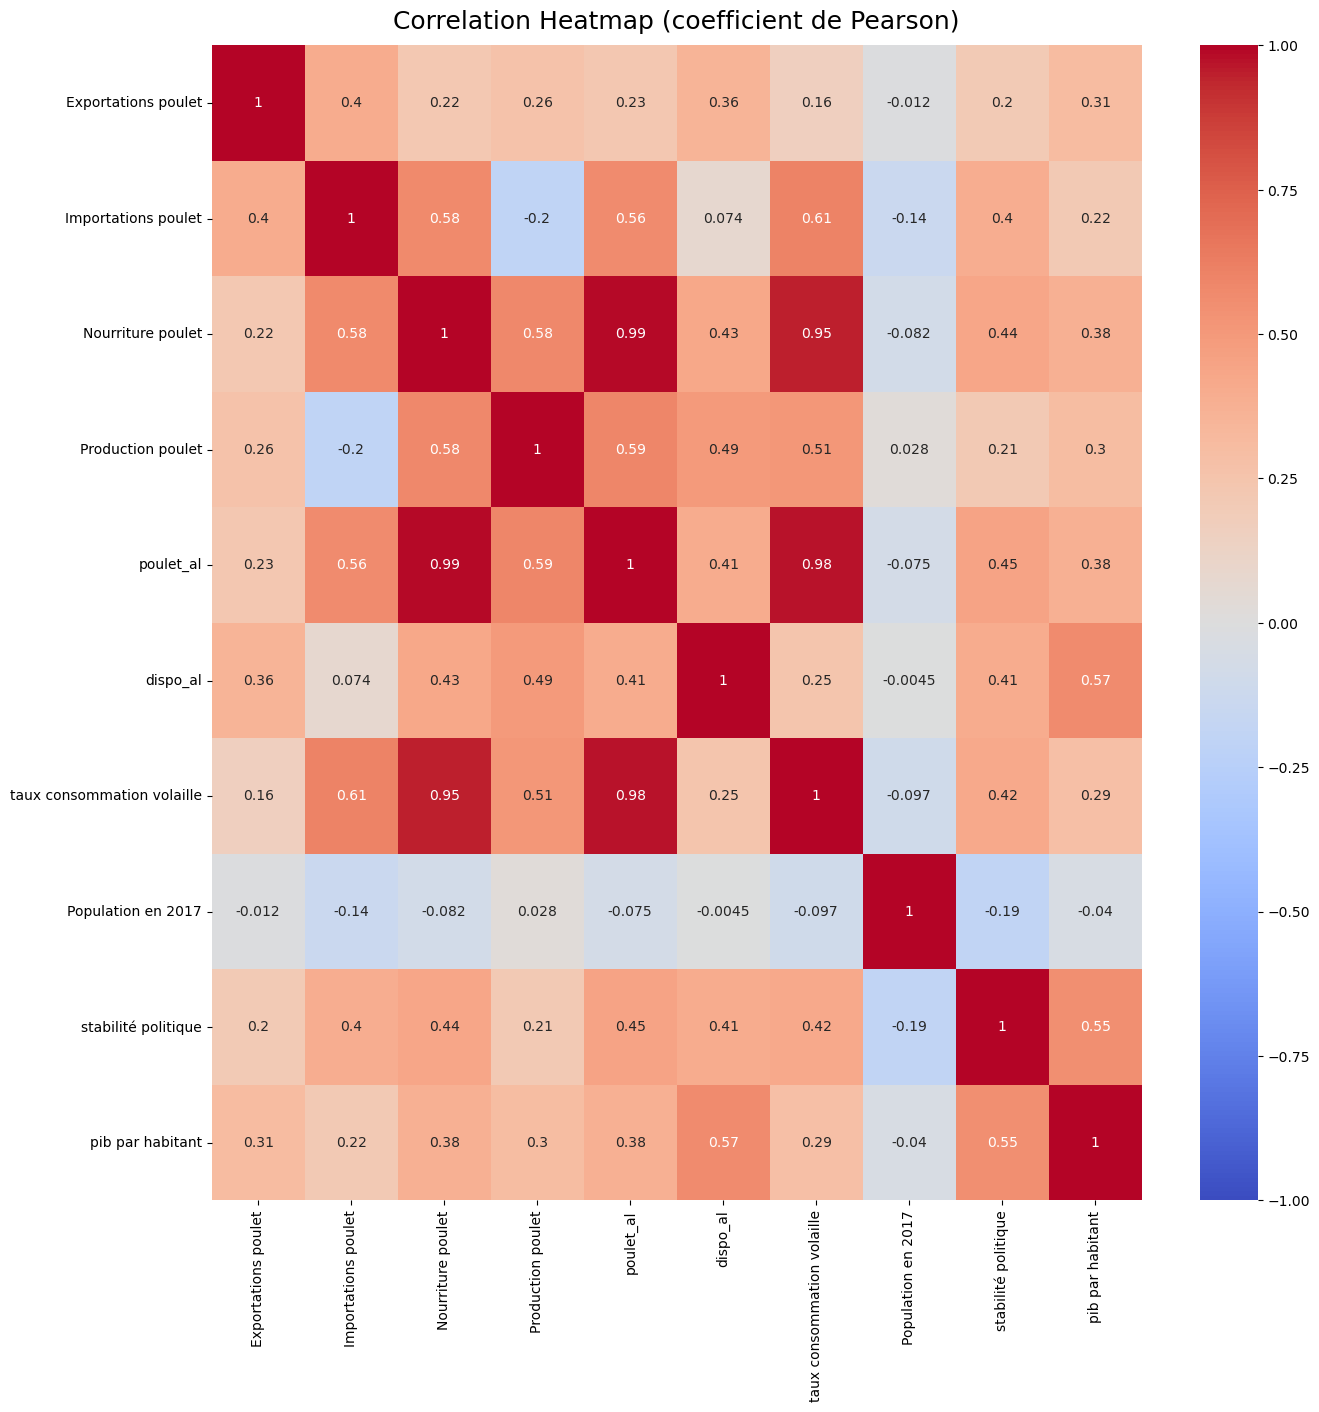

In [267]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_final.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)', fontdict={'fontsize':18}, pad=12)
plt.show()



In [268]:
# Observation graphiques des vraiables très fortement corrélées
selection =['Nourriture poulet', 
            'poulet_al',
            'taux consommation volaille' ]

import plotly.express as px

fig = px.scatter_matrix(df_final, dimensions=selection)
fig.update_traces(diagonal_visible=False)
fig.show()

**Les variables:'Nourriture poulet', 'poulet_al','taux consommation volaille' sont très fortement corrélées
(heatmap et graphiques ci-dessus) 
Seule la variable 'taux consommation volaille' sera conservée pour l'analyse.**

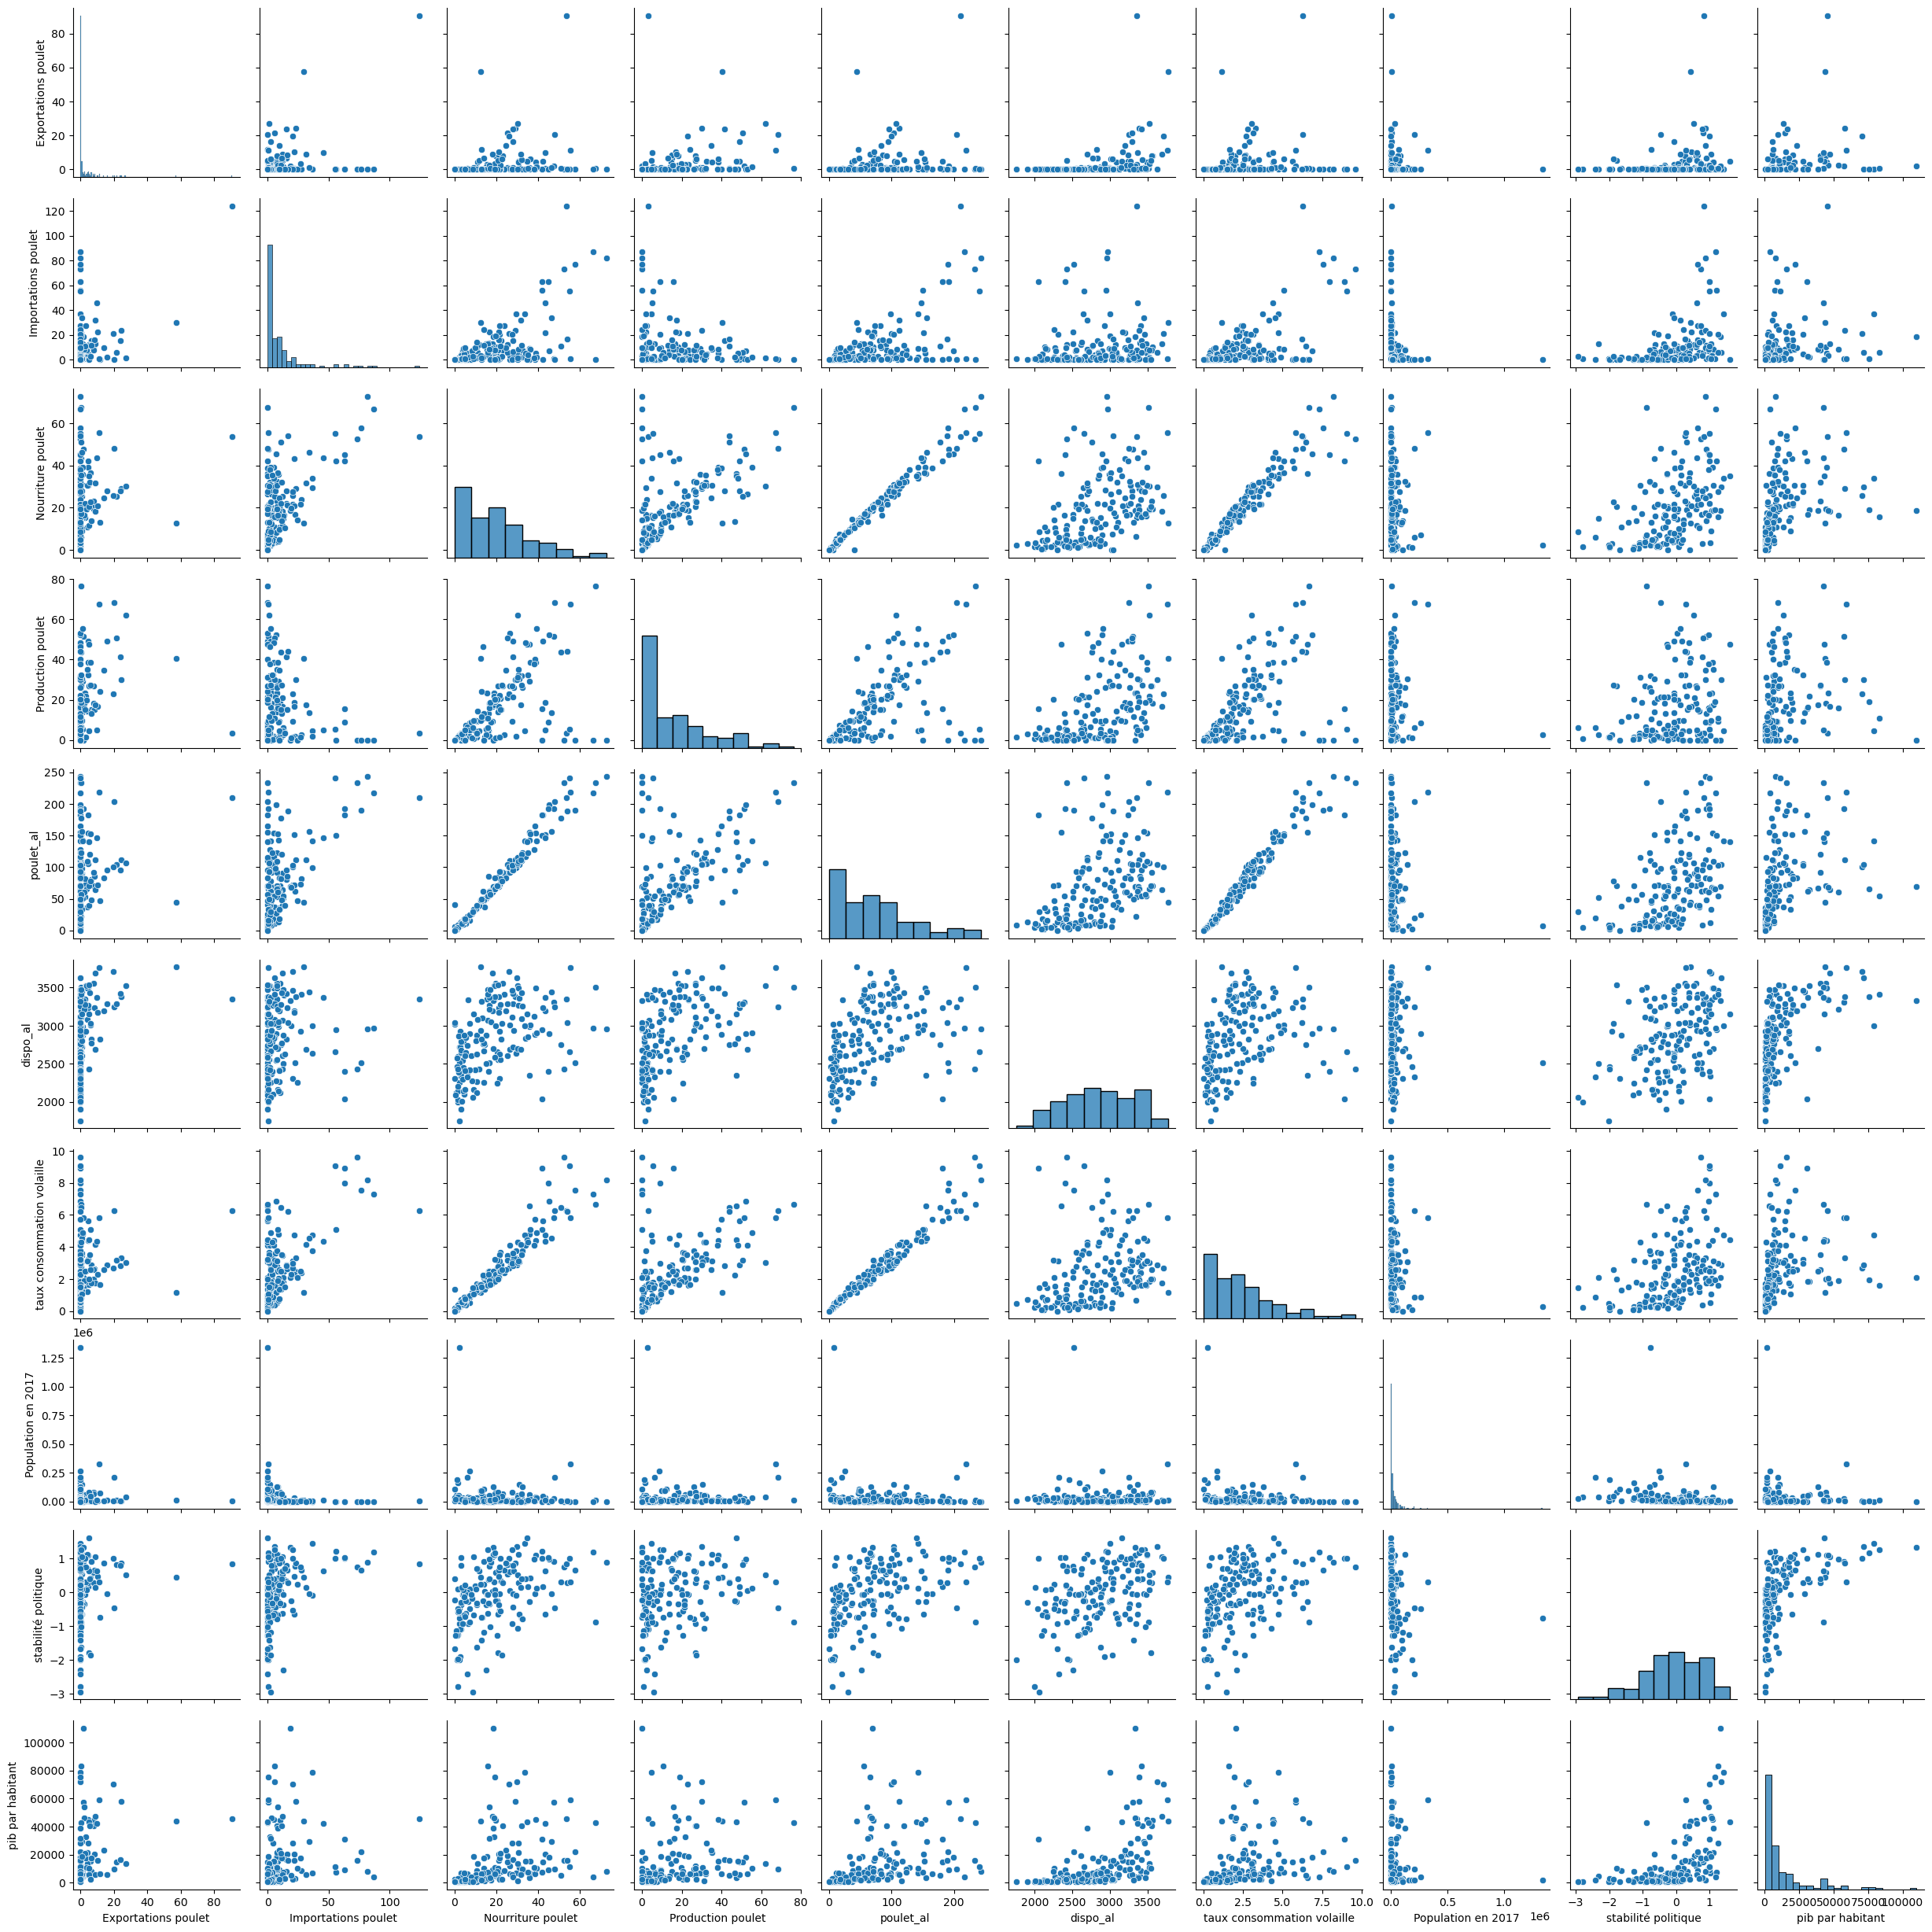

In [269]:
#Afficher les variables correlées autrement
#Affichage des variables deux à deux avec leur mode de distribution
sns.pairplot(data=df_final.iloc[:,1:])
plt.show()

**Quelques remarques peuvent-être apportées:
on constate une corrélation linéaire du taux de consommation volaille / poulet_al/ Nourriture poulet.
On a également une idée de la distribution de nos 9 principales variables, 
avec par exemple une distribution étalée à droite pour le ratio Population en 2017,
ou encore une distribution plutôt asymétrique, c'est à dire une distribution anormale pour la population en 2017.**

In [270]:
df_final.columns

Index(['pays', 'Exportations poulet', 'Importations poulet',
       'Nourriture poulet', 'Production poulet', 'poulet_al', 'dispo_al',
       'taux consommation volaille', 'Population en 2017',
       'stabilité politique', 'pib par habitant'],
      dtype='object')

In [271]:
#Supprimer les variables fortements corrélés
df_final.drop(columns=['Nourriture poulet','poulet_al'],inplace=True)
df_final

,pays,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
0,Afghanistan,0.000000,0.798984,0.771432,1997,0.250376,36296.113,-2.80,530.149831
1,Afrique du Sud,1.105074,9.016001,29.240609,2987,4.787412,57009.756,-0.28,6723.928582
2,Albanie,0.000000,13.175372,4.507364,3400,2.500000,2884.169,0.38,4521.752219
3,Algérie,0.000000,0.048322,6.644247,3345,0.657698,41389.189,-0.92,4134.936054
4,Allemagne,7.815297,10.186501,18.316346,3559,1.994942,82658.409,0.59,44670.222288
...,...,...,...,...,...,...,...,...,...
162,Émirats arabes unis,9.908084,45.640427,5.059447,3370,4.362018,9487.203,0.62,42522.377622
163,Équateur,0.000000,0.000000,20.255745,2585,3.210832,16785.361,-0.07,6246.404252
164,États-Unis d'Amérique,11.357038,0.378363,67.410113,3762,5.821372,325084.756,0.29,59059.596403
165,Éthiopie,0.000000,0.009399,0.131579,2304,0.000000,106399.924,-1.68,709.761008


In [272]:
#transformer pop en log afin de normaliser la distribution de Population en 2017
df_final['Population en 2017']=np.log(df_final['Population en 2017'])
df_final['Population en 2017']

0      10.499466
1      10.950978
2       7.966992
3      10.630775
4      11.322472
         ...    
162     9.157699
163     9.728262
164    12.691841
165    11.574960
166     6.455260
Name: Population en 2017, Length: 167, dtype: float64

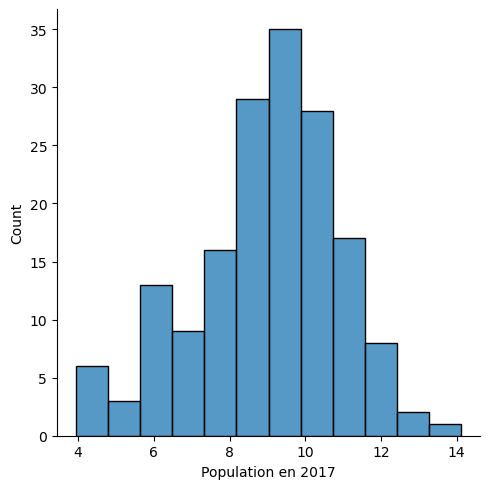

In [273]:
sns.displot(data=df_final,x='Population en 2017')
plt.show()

In [274]:
#Dataframe final prêt à l'analyse
df_final

,pays,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
0,Afghanistan,0.000000,0.798984,0.771432,1997,0.250376,10.499466,-2.80,530.149831
1,Afrique du Sud,1.105074,9.016001,29.240609,2987,4.787412,10.950978,-0.28,6723.928582
2,Albanie,0.000000,13.175372,4.507364,3400,2.500000,7.966992,0.38,4521.752219
3,Algérie,0.000000,0.048322,6.644247,3345,0.657698,10.630775,-0.92,4134.936054
4,Allemagne,7.815297,10.186501,18.316346,3559,1.994942,11.322472,0.59,44670.222288
...,...,...,...,...,...,...,...,...,...
162,Émirats arabes unis,9.908084,45.640427,5.059447,3370,4.362018,9.157699,0.62,42522.377622
163,Équateur,0.000000,0.000000,20.255745,2585,3.210832,9.728262,-0.07,6246.404252
164,États-Unis d'Amérique,11.357038,0.378363,67.410113,3762,5.821372,12.691841,0.29,59059.596403
165,Éthiopie,0.000000,0.009399,0.131579,2304,0.000000,11.574960,-1.68,709.761008


## <a name="C20"><font>Partie 3 : Analyse en composantes principales (ACP)</font></a> 

**L'ACP consiste à obtenir des variables synthétiques à partir des variables initiales. Cela doit nous permettre de:**

1. faciliter la visualisation des données
2. d'étudier la variabilité entre les individus
3. d'étudier les liaisons entre les variables
**L'ACP (Analyse en Composante Principale) permettra une visualisation des clusters pays sur le premier plan factoriel (ou plus). Il deviendra alors facile de pouvoir appréhender le "comportement" des différents groupes.**

**Nous allons reprendre notre dataframe final et le préparer pour réaliser l'ACP.**

**Pour effectuer une Analyse en Composantes Principales (ACP), la première étape consiste à extraire les données numériques de notre dataframe actuel et à les placer dans une matrice séparée, appelée "X".**

In [275]:
# On sélectionne uniquement les données de type numérique
X = df_final.select_dtypes(exclude= ['object']).values # Matrice des données(Transformation en array Numpy)
X[:5]

array([[ 0.00000000e+00,  7.98983627e-01,  7.71432467e-01,
         1.99700000e+03,  2.50375563e-01,  1.04994659e+01,
        -2.80000000e+00,  5.30149831e+02],
       [ 1.10507402e+00,  9.01600070e+00,  2.92406093e+01,
         2.98700000e+03,  4.78741212e+00,  1.09509777e+01,
        -2.80000000e-01,  6.72392858e+03],
       [ 0.00000000e+00,  1.31753722e+01,  4.50736417e+00,
         3.40000000e+03,  2.50000000e+00,  7.96699210e+00,
         3.80000000e-01,  4.52175222e+03],
       [ 0.00000000e+00,  4.83217973e-02,  6.64424712e+00,
         3.34500000e+03,  6.57698057e-01,  1.06307750e+01,
        -9.20000000e-01,  4.13493605e+03],
       [ 7.81529681e+00,  1.01865014e+01,  1.83163458e+01,
         3.55900000e+03,  1.99494240e+00,  1.13224718e+01,
         5.90000000e-01,  4.46702223e+04]])

### <a name="C21">1. Centrage et réduction des données</a>

**Avant de se plonger dans l'analyse en composantes principales et le regroupement par clusters, il faut standardiser nos données pour rendre comparables nos variables entre elles. 
Pour chaque valeur on lui soustrait la moyenne de la variable et on divise par l'écart-type.**


In [276]:
X = df_final.select_dtypes(exclude= ['object']).values  # Matrice des données(Transformation en array Numpy)
names = df_final.index # Noms des individus
features = df_final.select_dtypes(exclude=['object']).columns # Noms des variables

p = df_final.shape[1] # nb de variables

#Instanciation et application du scaler

scaler = StandardScaler() # Instanciation du scaler
X_scaled = scaler.fit_transform(X) # Données scalées(centrer et réduire)
X_scaled 

array([[-0.32315231, -0.52616581, -0.88187602, ...,  0.79657101,
        -3.03534231, -0.68380728],
       [-0.20592533, -0.07774204,  0.79289876, ...,  1.03574805,
        -0.22769904, -0.36085619],
       [-0.32315231,  0.14924557, -0.66209993, ..., -0.5449436 ,
         0.5076361 , -0.47568032],
       ...,
       [ 0.88160976, -0.54912017,  3.03832095, ...,  1.95792692,
         0.40736313,  2.36798869],
       [-0.32315231, -0.5692555 , -0.91951709, ...,  1.36628713,
        -1.78750086, -0.67444214],
       [-0.32315231, -0.05496437, -0.92725758, ..., -1.34574589,
         0.30709015, -0.59238126]])

In [277]:
# Visualisation de la moyenne et de l'écart-type : attendu moy = 0 et std =1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**On a bien nos données qui sont centrées et réduites,La moyenne est égale à 0 et l'écart type à 1.**

In [278]:
# On créer un dataframe à partir des données centrées-réduites
df_x_scaled = pd.DataFrame(X_scaled, columns= features, index= names)
df_x_scaled.head(3)

,Exportations poulet,Importations poulet,Production poulet,dispo_al,taux consommation volaille,Population en 2017,stabilité politique,pib par habitant
0,-0.323152,-0.526166,-0.881876,-1.870378,-1.081151,0.796571,-3.035342,-0.683807
1,-0.205925,-0.077742,0.792899,0.291250,1.106821,1.035748,-0.227699,-0.360856
2,-0.323152,0.149246,-0.662100,1.193021,0.003724,-0.544944,0.507636,-0.475680


### <a name="C22">2. Détermination du nombre de composantes principales</a>

**On commence par réaliser l'ACP pour le maximum de variables synthétiques (ou composantes principales) soit 8. Ensuite on regarde quel nombre de composantes principales nous permet de conserver une quantité raisonnable d'information et on lance une ACP pour ce nombre de composantes.**   

In [279]:
# On part des données centrées-réduites (ici  j'affiche les 3 premiers individus)
X_scaled[:3]

array([[-0.32315231, -0.52616581, -0.88187602, -1.87037775, -1.08115067,
         0.79657101, -3.03534231, -0.68380728],
       [-0.20592533, -0.07774204,  0.79289876,  0.2912504 ,  1.10682105,
         1.03574805, -0.22769904, -0.36085619],
       [-0.32315231,  0.14924557, -0.66209993,  1.19302053,  0.0037237 ,
        -0.5449436 ,  0.5076361 , -0.47568032]])

In [280]:
# On choisit le maximum de variables synthétiques possibles pour commencer
n_components = n_composantes = 8

# Instanciation de l'ACP
acp = PCA()# acp est le nombre de composantes principales générées par votre PCA

# Entraînement sur les données scalées
acp.fit(X_scaled)
PCA(n_components=8)

PCA(n_components=8)

In [281]:
#On affiche le pourcentage de variance captée par chacune des composantes
# Mettre à jour la variable p pour correspondre au nombre de composantes principales
p = len(acp.explained_variance_)


# Créer le DataFrame scree
scree = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)],
        "Variance expliquée" : acp.explained_variance_,
        "% variance expliquée" : np.round(acp.explained_variance_ratio_ * 100),#on définit le % dinertie pour chaque rang
        "% cum. var. expliquée" : np.round(np.cumsum(acp.explained_variance_ratio_) * 100)#On calcule la somme cumulée
                                                                                          #du % d'inertie
    }
)
scree

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,3.111528,39.0,39.0
1,Dim2,1.836777,23.0,61.0
2,Dim3,1.006879,13.0,74.0
3,Dim4,0.939345,12.0,86.0
4,Dim5,0.479551,6.0,92.0
5,Dim6,0.382573,5.0,96.0
6,Dim7,0.263205,3.0,100.0
7,Dim8,0.028335,0.0,100.0


**Je m'intéresse aux  premières composantes :Les 4 premières composantes permettent d'expliquer plus de 86% de la variance.**

### <a name="C23">3. Création de l'éboulis des valeurs propres</a>

**On crée un éboulis de valeur, afin de pouvoir déterminer le nombre de rang que l'on va utiliser pour notre ACP et nos plans factoriels.**

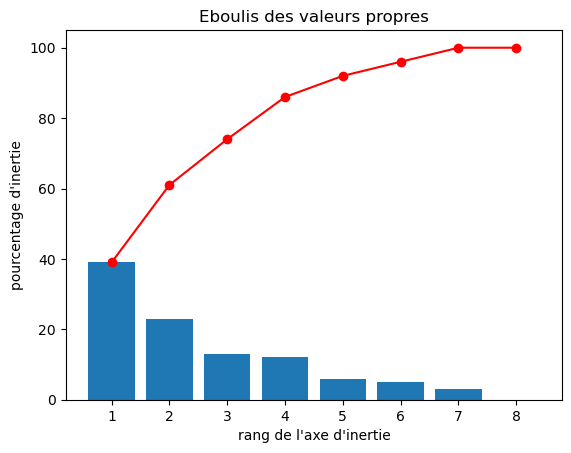

In [282]:
# liste des composants (indice des composantes)
x_list = range(1, p+1)
list(x_list)
# On représente le pourcentage d'inertie expliquée par chaque composantes principales et la somme cumulée de ce pourcentage
# Représentation graphiques des valeurs propres
plt.bar(x_list, scree['% variance expliquée'])
plt.plot(x_list, scree['% cum. var. expliquée'],c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

**On va garder les 4 premiers axes d'inertie ce qui va nous permettre d'avoir plus de 87 % d'inertie cumulée.**


In [283]:
#on va utiliser le critère de kaiser pour déterminer le nombre des composantes
# Obtenir les valeurs propres
eigenvalues = acp.explained_variance_

# Appliquer le critère de Kaiser
components_to_keep = eigenvalues > 1

# Afficher les composantes à conserver
print(f"Composantes à conserver selon le critère de Kaiser : {components_to_keep.sum()}")

Composantes à conserver selon le critère de Kaiser : 3


In [284]:
# critère de Kaiser
p = len(df_final.columns)
kaiser = 100 / p
print(round(kaiser,2), "%") # critère à vérifier

11.11 %


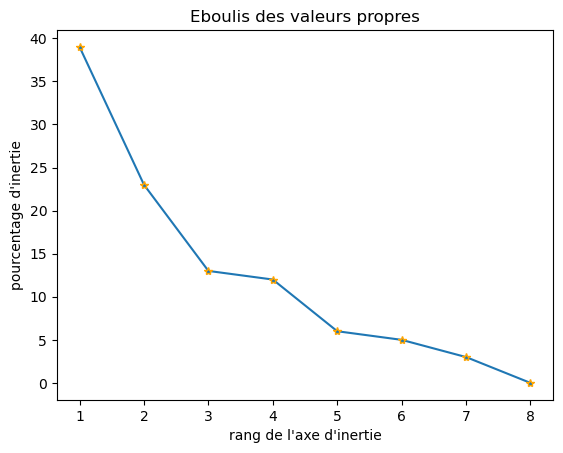

In [285]:
# Représentation graphiques des valeurs propres (visualisation des valeurs propres) - méthode du coude
plt.plot(x_list, scree['% variance expliquée'],marker='*', markeredgecolor="orange")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

**La méthode du coude précise une forte représentation de nos variables sur les 3 premières composantes principales, le premier axe factoriel.**

On observe un coude pour 3 composantes principales, ensuite le pourcentage d'inertie (ou de variance) expliqué diminue plus lentement. D'après nos deux graphiques il serait intéressant de ne retenir que les 3 premières composantes. Cependant, dans le cadre de notre analyse, nous décidons de ne garder que les deux premières composantes. Pour ce faire, nous utilisons le critère de Kaiser qui indique qu'il est possible de ne pas considérer les composantes principales qui expliquent moins de variance que les variables initiales.

Critère de Kaiser: (100/p) en % avec p nombre de variables
Avec 8 variables initiales le critère est de 11.11 % et la troisième variable n'explique qu'environ 11 % de la variance, ainsi on peut considérer seulement les deux premières composantes.


### <a name="C24">4. Construction des composantes principales</a>

In [286]:
# On relance une PCA mais pour 2 composantes principales
n_components = 2

# On instancie
acp = PCA(n_components= n_components)# Utilisation du point "coude" pour fixer le nombre de composantes

# On entraine
acp.fit(X_scaled)

PCA(n_components=2)

In [287]:
# Coordonnées des variables sur le premier plan factoriel F1-F2
pcs = acp.components_
pcs

array([[ 0.288157  ,  0.35048706,  0.27352942,  0.35973189,  0.41886468,
        -0.24702848,  0.44071989,  0.39899158],
       [-0.16550395,  0.45269081, -0.47010881, -0.40904006,  0.13107388,
        -0.55026985,  0.12836979, -0.20714088]])

### <a name="C25">5. Cercles de corrélations</a>

**Nous pouvons maintenant tracer le cercle des corrélations et étudier les relations entre les variables initiales et nos composantes principales.**

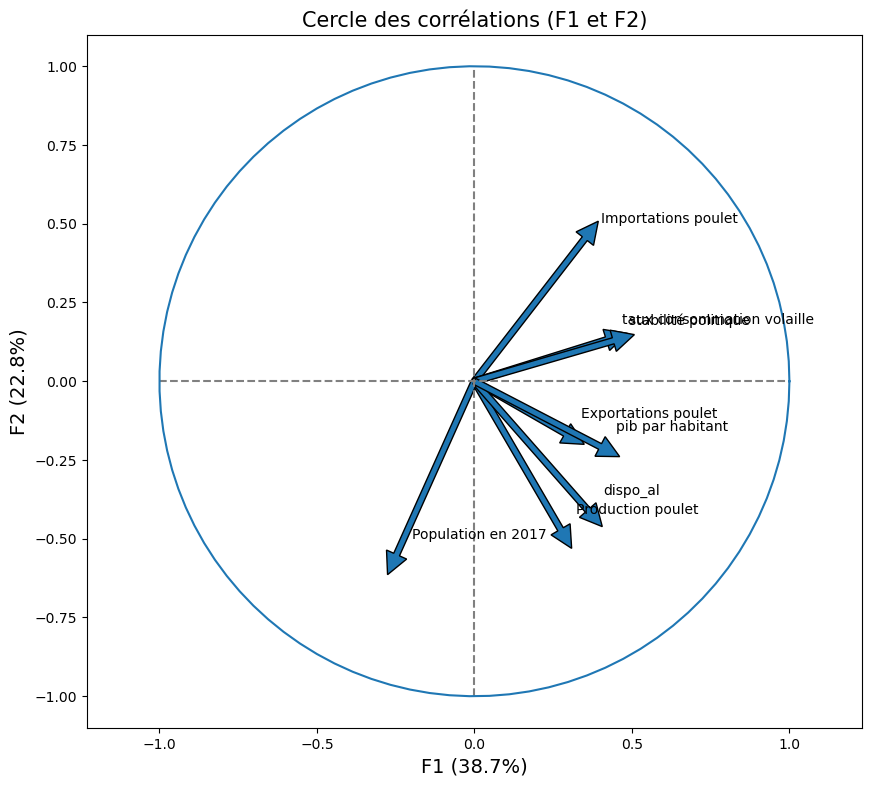

In [288]:
#Graphe de corrélation entre pc1 et pc2
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pcs.shape[1]):
    ax.arrow(0,
             0,  # La flèche commence à l'origine
             pcs[0, i],  #0 for PC1
             pcs[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )
    
# On affiche le nom des variables
    plt.text(pcs[0, i] + 0.05,
             pcs[1, i] + 0.05,
             df_final.columns[i+1])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(1, round(100*acp.explained_variance_ratio_[0],1)), fontsize=14)
plt.ylabel('F{} ({}%)'.format(2, round(100*acp.explained_variance_ratio_[1],1)), fontsize=14)

plt.title("Cercle des corrélations (F1 et F2)", fontsize=15)

# On ajoute le cercle unitaire
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)



**Recherche des groupes de variables fortement corrélées deux à deux entre elles, l'objectif est de pouvoir les synthétiser par une variable unique F1 et F2 (nos composantes principales).


**On voit une forte corrélation entre le taux de consommation de volaille et la stabilité politique qui est fortement corrélée à l'axe F1. On remarque également une corrélation avec l'exportation et le pib par habitant.**

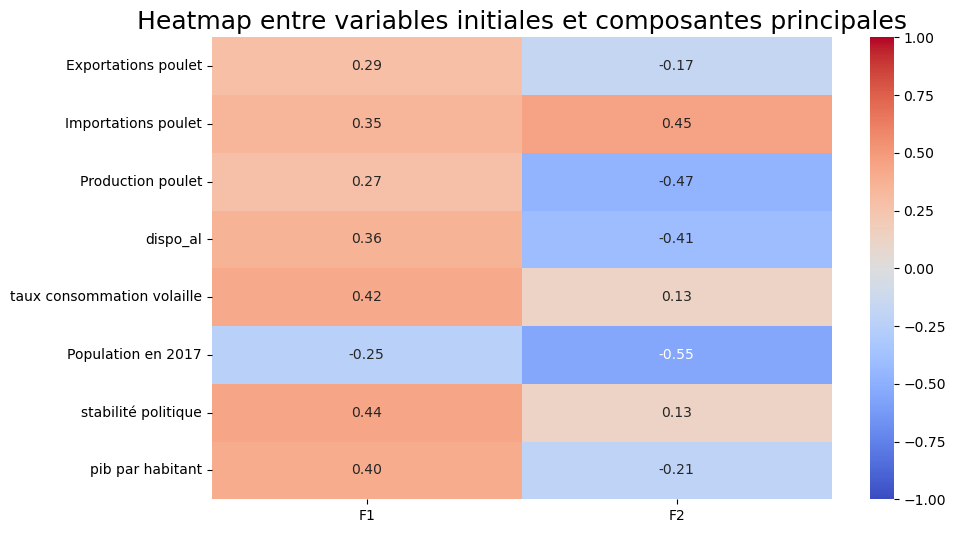

In [289]:
# On peut aussi visualiser les liens entre les variables initiales et F1 et F2 grâce à une heatmap
pcs = pd.DataFrame(pcs)
n = pcs.shape[1]
x_list = [1, 2]
pcs.columns = df_final.columns[1:n+1]
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

pcs.T

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Heatmap entre variables initiales et composantes principales", fontsize= 18)
plt.show()

#### <font color='indianred'>Projection du nuage des individus sur le plan F1-F2</font>
**On s'intéresse maintenant à nos pays, pour ce faire on projette le nuage de points représentant les pays, sur le premier plan factoriel F1/F2.**

In [290]:
# On applique la réduction de dimension à nos données centrées-réduites
X_proj = acp.transform(X_scaled)

# On converti en dataframe
X_proj = pd.DataFrame(X_proj, columns = ["F1", "F2"], index = df_final.index)
X_proj.head()

,F1,F2
0,-3.451787,0.166888
1,0.198486,-0.872341
2,0.377363,0.408363
3,-1.249627,-1.000583
4,1.303434,-1.740197


### <a name="C26">6. Projection des pays sur les axes F1 et F2</a>

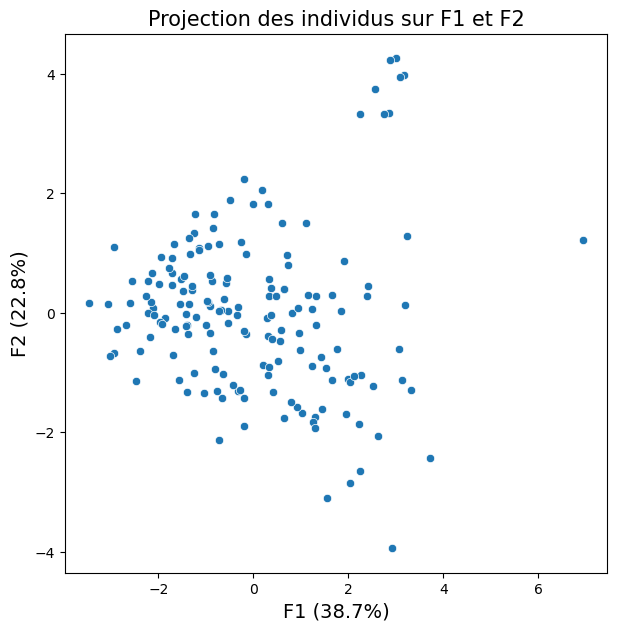

In [291]:
# On représente nos individus sur le premier plan factoriel
plt.figure(figsize=(7, 7))

# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(1, round(100*acp.explained_variance_ratio_[0],1)), fontsize= 14)
plt.ylabel('F{} ({}%)'.format(2, round(100*acp.explained_variance_ratio_[1],1)), fontsize= 14)

sns.scatterplot(data= X_proj, x="F1", y="F2", palette="muted")
   
plt.title("Projection des individus sur F1 et F2",fontsize=15)
plt.show()

**On observe une répartition homogène des pays sur les deux axes F1 et F2.**

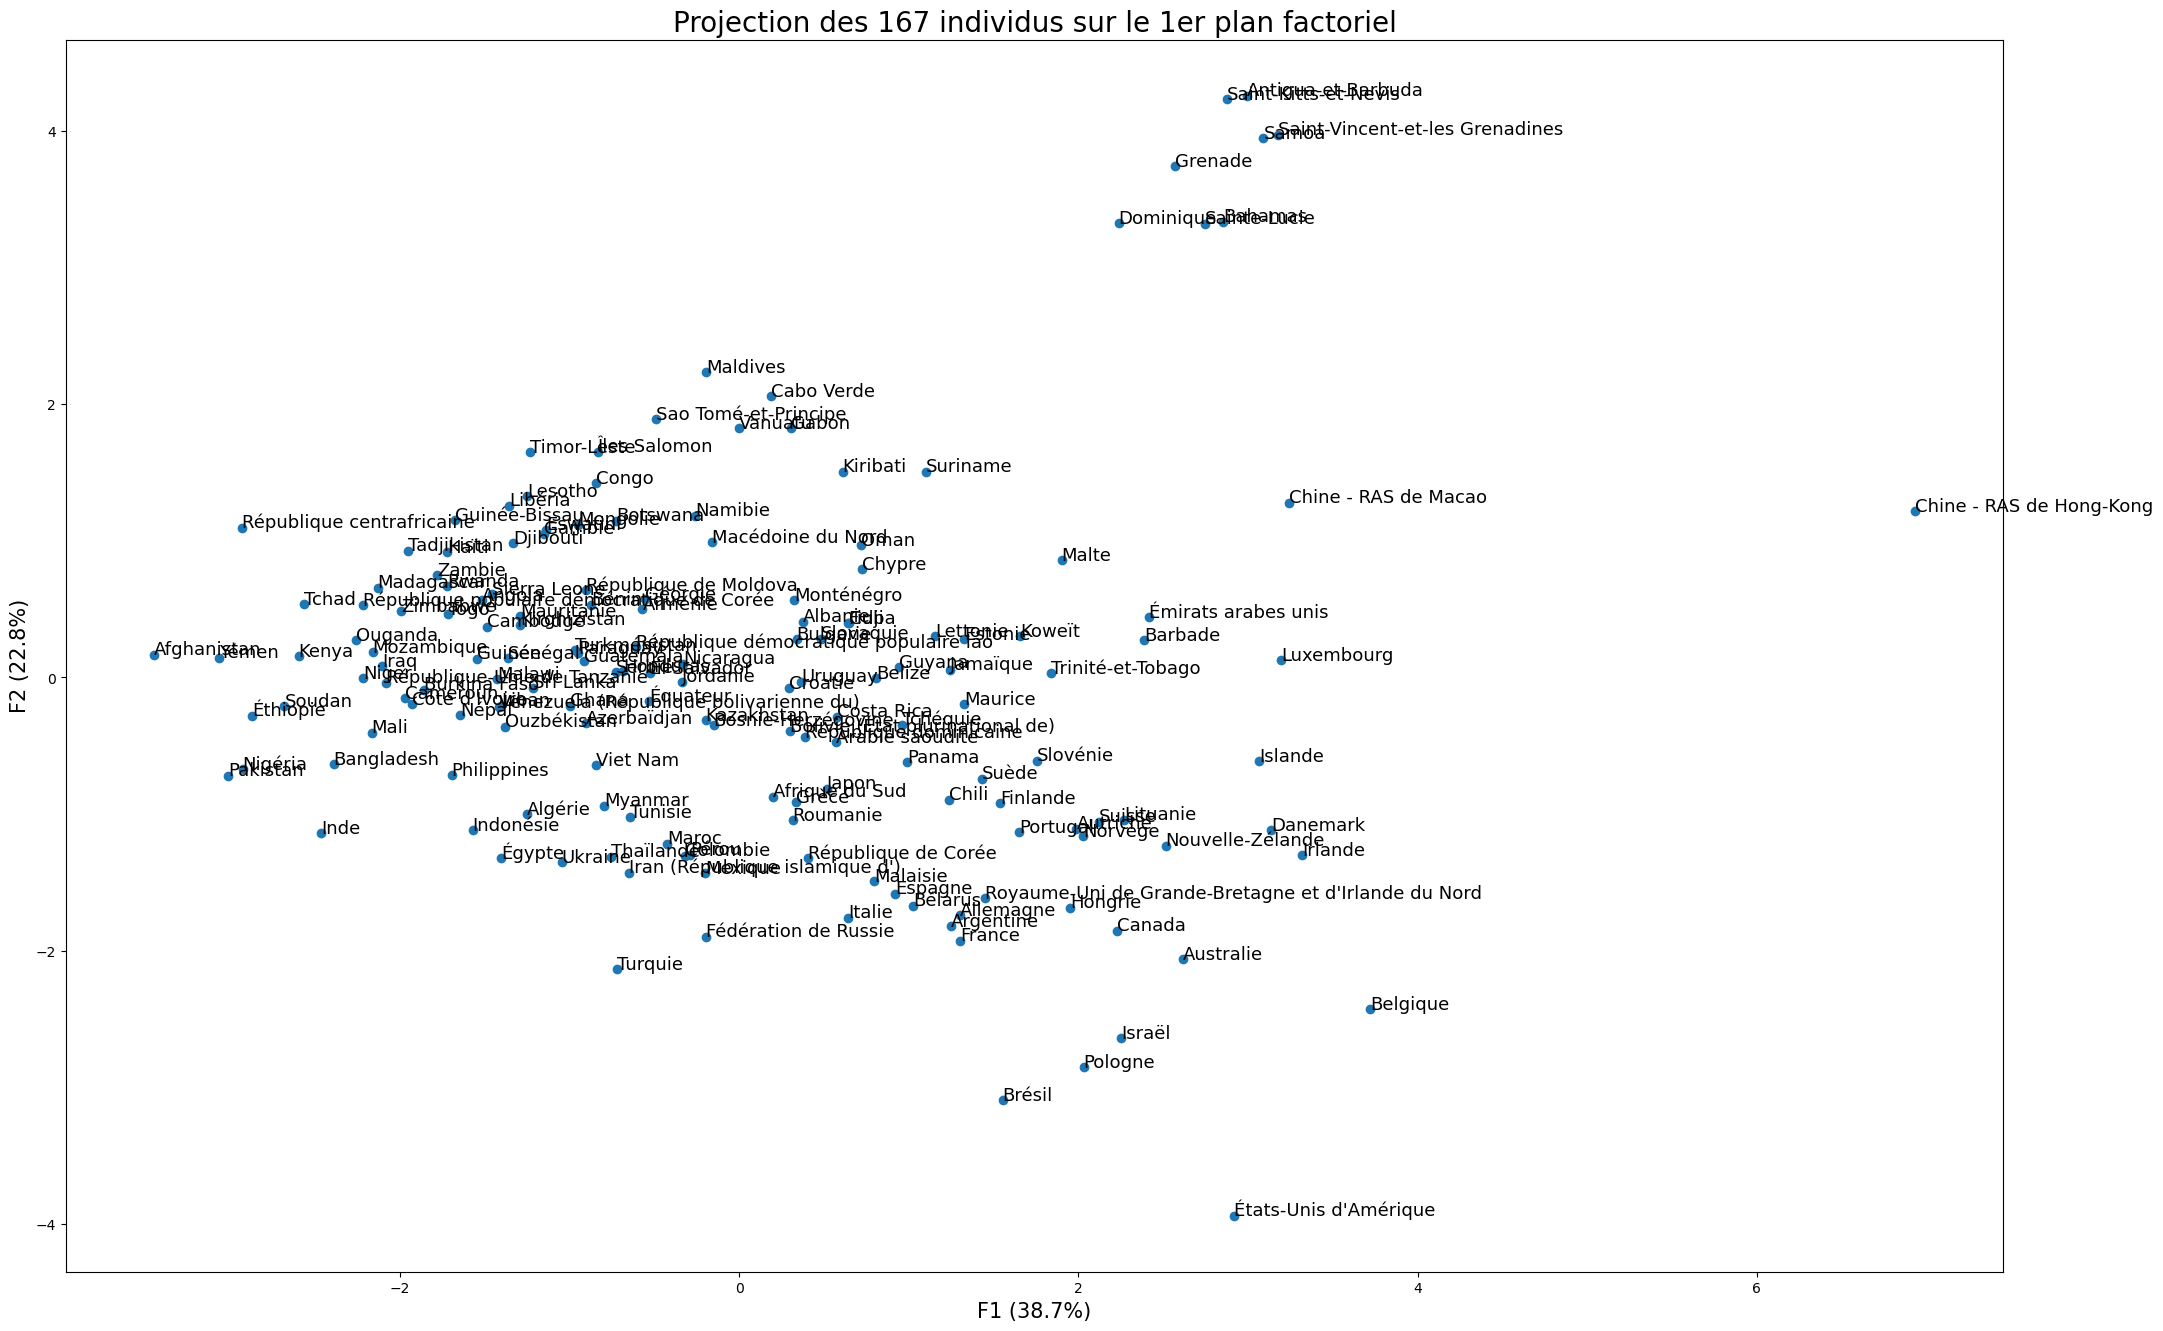

In [292]:
#Coordonnées factorielles 
X_projected = acp.transform(X_scaled)
plt.figure(figsize=(25, 16))

plt.scatter(X_projected[:, 0], X_projected[:, 1],)
for i,(x,y) in enumerate(X_projected[:,[0,1]]):
                    plt.text(x, y, df_final.pays[i], fontsize='13') 

plt.xlabel('F{} ({}%)'.format(1, round(100*acp.explained_variance_ratio_[0],1)), fontsize=15)
plt.ylabel('F{} ({}%)'.format(2, round(100*acp.explained_variance_ratio_[1],1)), fontsize=15)
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

plt.show()

**Cette projection est très intéressante car elle nous apporte une vision globale des pays. Par exemple, les pays plus à droite présentent un meilleur PIB/habitant avec un potientiel en exportation du poulet élevées.**

In [293]:
#Affichage des 40 pays les plus contributeurs 
df_final.set_index('pays', inplace=True)
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame(di,index=df_final.index, columns=['d_i']).sort_values(by='d_i', ascending=False)
ctr_indiv_inertie[:40]

,d_i
pays,
Chine - RAS de Hong-Kong,133.900308
Belgique,43.813117
Luxembourg,31.935254
Antigua-et-Barbuda,31.724026
Saint-Vincent-et-les Grenadines,30.258877
Samoa,29.962794
Saint-Kitts-et-Nevis,28.576194
États-Unis d'Amérique,26.428420
Bahamas,25.834488


## <a name="C27"><font>Partie 4 : Export</font></a>
**Maintenant on exporte les dataframe afin de classifier les données dans un autre Notebook.**

In [294]:
df_final.to_csv("df_final.csv", index= True)
df_x_scaled.to_csv("df_X_scaled.csv", index=True)

****Notebook 2 - Clustering - Visualisation****

****Partie 5- Clustering****